In [1]:
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

# Ensure deterministic behavior (cannot control everything though)
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# !nvidia-smi

In [2]:
dir_ = '/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/'

In [3]:
import argparse
import ast
import torch
from PIL import Image
import cv2
import os
import sys

sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/')

from mobilesamv2.promt_mobilesamv2 import ObjectAwareModel
from mobilesamv2 import sam_model_registry, SamPredictor
from typing import Any, Dict, Generator,List
import matplotlib.pyplot as plt
import numpy as np

def create_model():
    Prompt_guided_path=dir_+'PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    obj_model_path=dir_+'weight/ObjectAwareModel.pt'
    ObjAwareModel = ObjectAwareModel(obj_model_path)
    PromptGuidedDecoder=sam_model_registry['PromptGuidedDecoder'](Prompt_guided_path)
    mobilesamv2 = sam_model_registry['vit_h']()
    mobilesamv2.prompt_encoder=PromptGuidedDecoder['PromtEncoder']
    mobilesamv2.mask_decoder=PromptGuidedDecoder['MaskDecoder']
    return mobilesamv2,ObjAwareModel

def show_anns(image, anns, random_color=True):
    # plt.imshow(image)

    for ann in anns:
        mask = ann.detach().cpu().numpy()
        print(mask.shape, np.max(mask), np.min(mask))
        
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = np.zeros((h, w, 4))
        print(np.min(mask_image), np.max(mask_image))
        mask_image[mask > 0] = color
        plt.imshow(mask_image)

        plt.show()
    plt.close()

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

encoder_path={'efficientvit_l2':dir_+'weight/l2.pt',
            'tiny_vit':dir_+'weight/mobile_sam.pt',
            'sam_vit_h':dir_+'weight/sam_vit_h.pt',}

/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid

In [4]:
# Load bboxes from source detection & deblending
import json
import time

# image_path = '/workspace/raid/OM_DeepLearning/XMM_OM_code/scaled_raw/clahe_S0720251301_L.png'

def remove_boxes_near_corners(boxes, img_width, img_height, distance):
    """
    Remove bounding boxes that are within a certain distance from the corners of the image.

    Args:
        boxes (list): List of bounding boxes. Each box is a tuple (x1, y1, x2, y2).
        img_width (int): Width of the image.
        img_height (int): Height of the image.
        distance (int): The distance from the corners.

    Returns:
        list: The list of remaining bounding boxes.
    """
    
    corners = [(0, 0), (img_width, 0), (0, img_height), (img_width, img_height)]
    new_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = box
        box_center = ((x1 + x2) / 2, (y1 + y2) / 2)
        if all(np.sqrt((cx - box_center[0]) ** 2 + (cy - box_center[1]) ** 2) > distance for cx, cy in corners):
            new_boxes.append(box)
    return new_boxes
    
with open('extracted_sources_bboxes_points.json', 'r') as f:
    extracted_bboxes_points = json.load(f)

In [5]:
extracted_bboxes_points['bboxes']

{'S0674810801_M.png': [],
 'S0048740101_U.png': [[436, 50, 31, 29],
  [34, 76, 25, 22],
  [303, 99, 13, 14],
  [86, 125, 13, 15],
  [174, 137, 14, 27],
  [244, 180, 31, 26],
  [405, 241, 16, 14],
  [210, 262, 13, 12],
  [217, 357, 14, 12],
  [487, 376, 20, 58],
  [252, 393, 15, 12],
  [247, 404, 15, 12],
  [114, 414, 13, 12],
  [96, 433, 13, 12],
  [351, 451, 14, 15],
  [190, 467, 18, 18],
  [465, 492, 17, 12],
  [443, 0, 38, 19],
  [474, 0, 25, 26],
  [472, 11, 27, 27],
  [-3, 16, 25, 12],
  [144, 16, 23, 14],
  [400, 54, 19, 13],
  [365, 76, 33, 32],
  [218, 212, 18, 16],
  [214, 218, 40, 34],
  [243, 223, 33, 42],
  [263, 241, 13, 13],
  [218, 243, 14, 12],
  [222, 242, 34, 27],
  [259, 255, 25, 20],
  [267, 265, 15, 13],
  [155, 234, 44, 48],
  [185, 265, 18, 14],
  [160, 299, 43, 47],
  [153, 320, 14, 12],
  [160, 319, 15, 14],
  [166, 323, 14, 15],
  [377, 415, 22, 17],
  [369, 419, 22, 17],
  [373, 426, 26, 24],
  [491, 464, 16, 18],
  [484, 474, 15, 15],
  [479, 477, 28, 27],
 

In [6]:
class Args:
    ObjectAwareModel_path = dir_+'PromptGuidedDecoder/ObjectAwareModel.pt'
    Prompt_guided_Mask_Decoder_path = dir_+'PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    encoder_path = dir_
    img_path = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_rescaled_SAM_stats/'
    imgsz = 512
    iou = 0.9
    conf = 0.4
    retina = True
    output_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/output_mobileSAMv2/'
    encoder_type = 'tiny_vit'  # choose from ['tiny_vit','sam_vit_h','mobile_sam','efficientvit_l2','efficientvit_l1','efficientvit_l0']

args = Args()

# import pdb;pdb.set_trace()
output_dir=args.output_dir  
mobilesamv2, ObjAwareModel=create_model()
image_encoder=sam_model_registry[args.encoder_type](encoder_path[args.encoder_type])
mobilesamv2.image_encoder=image_encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
mobilesamv2.to(device=device)
mobilesamv2.eval()
predictor = SamPredictor(mobilesamv2)
image_files= os.listdir(args.img_path)

S0674810801_M.png



0: 512x512 2 objects, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 5.8ms postprocess per image at shape (1, 3, 512, 512)


512 512
asf [ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],

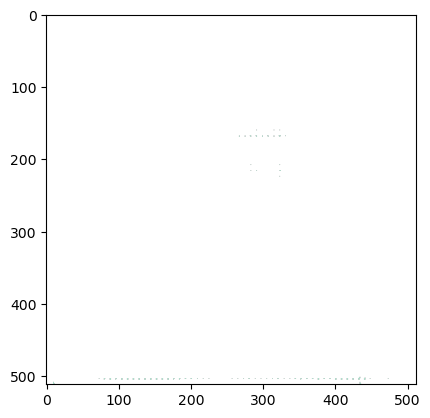

(512, 512) 1.0 0.0
0.0 0.0


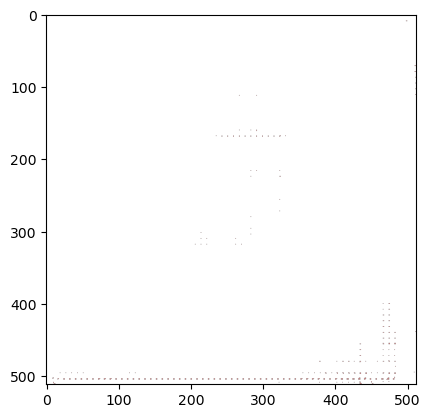

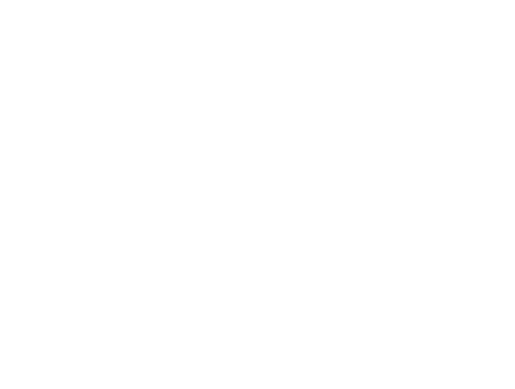


0: 512x512 4 objects, 8.3ms
Speed: 0.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


S0048740101_U.png
512 512
asf [ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,


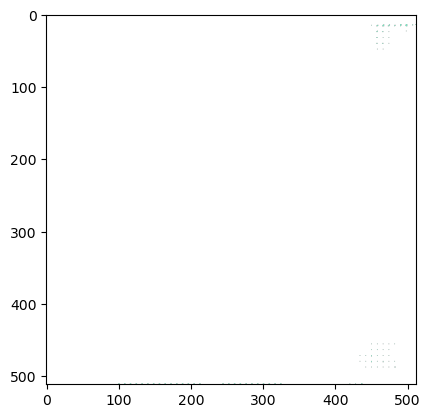

(512, 512) 1.0 0.0
0.0 0.0


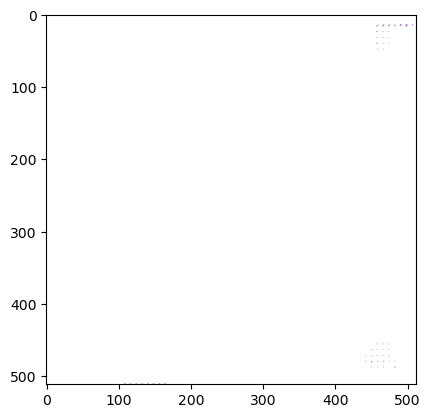

(512, 512) 1.0 0.0
0.0 0.0


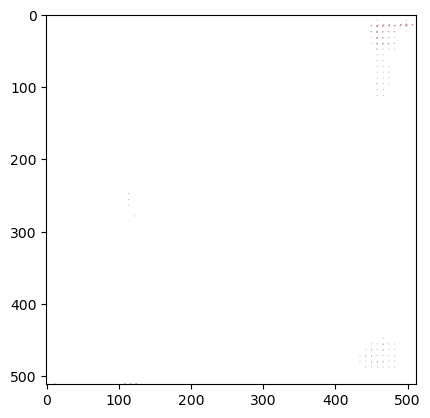

(512, 512) 1.0 0.0
0.0 0.0


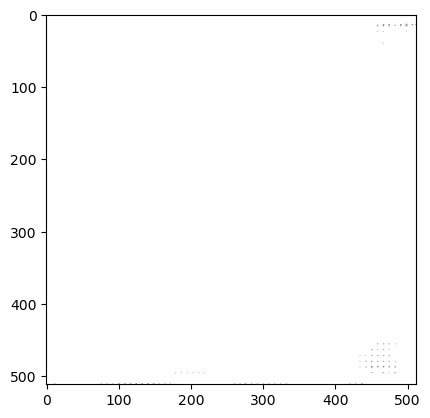

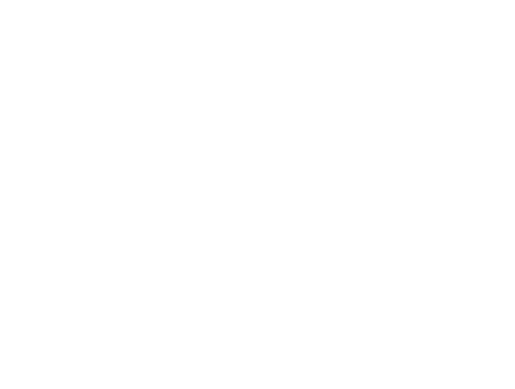


0: 512x512 1 object, 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)


S0655571401_L.png
512 512
asf [ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,


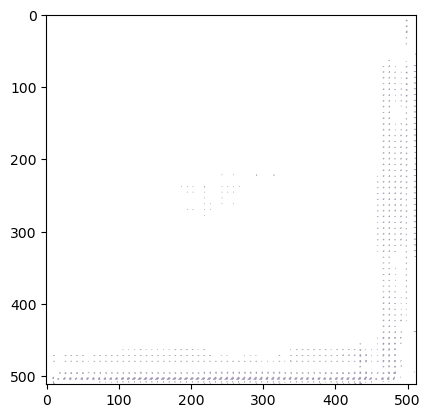

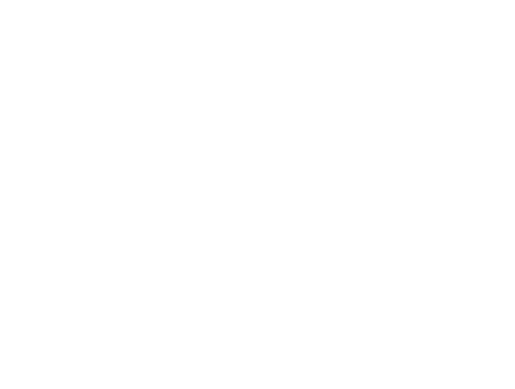


0: 512x512 3 objects, 8.4ms
Speed: 1.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


S0893811101_V.png
512 512
asf [ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,


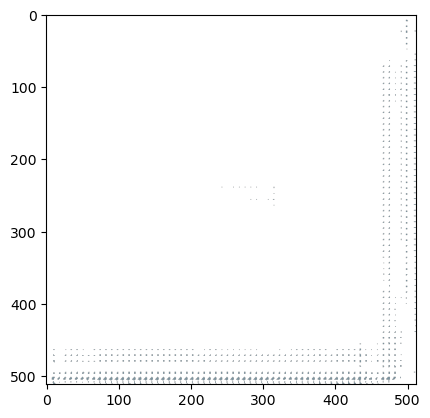

(512, 512) 1.0 0.0
0.0 0.0


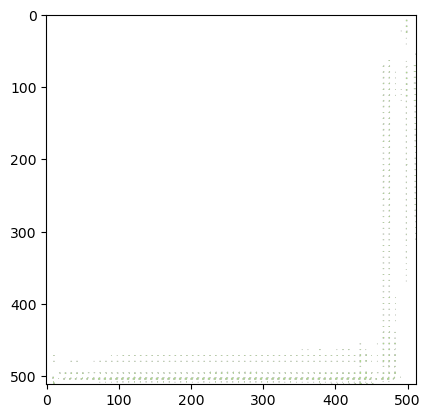

(512, 512) 1.0 0.0
0.0 0.0


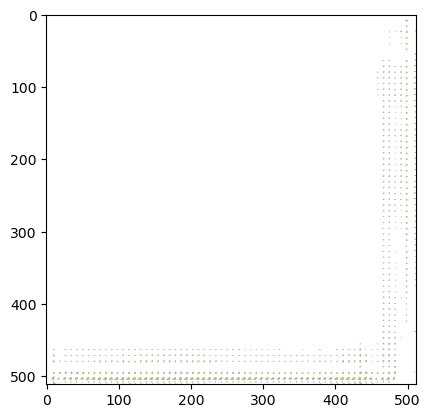

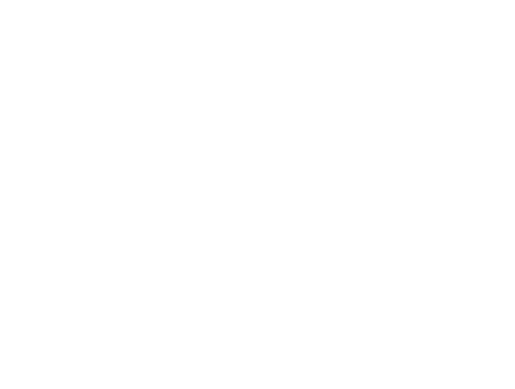


0: 512x512 2 objects, 8.4ms
Speed: 1.0ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


S0804790401_M.png
512 512
asf [ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes', 'masks']
masks: ultralytics.yolo.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,


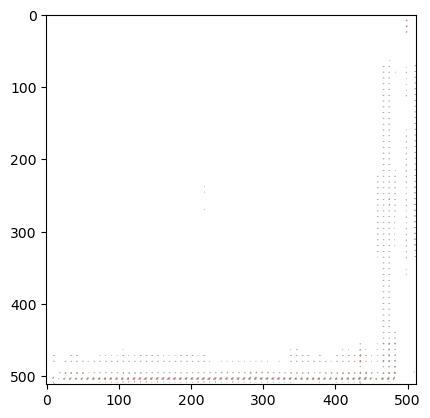

(512, 512) 1.0 0.0
0.0 0.0


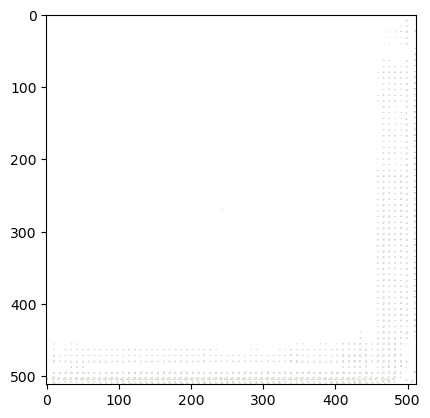

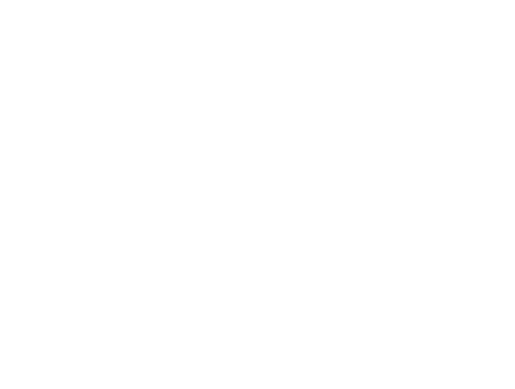

In [7]:
for image_name in image_files[:5]:
    print(image_name)
    image = cv2.imread(args.img_path + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    obj_results = ObjAwareModel(image,device=device,retina_masks=args.retina,imgsz=args.imgsz,conf=args.conf,iou=args.iou)
    print('asf', obj_results)
    predictor.set_image(image)
    input_boxes1 = obj_results[0].boxes.xyxy
    input_boxes = input_boxes1.cpu().numpy()
    input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
    input_boxes = torch.from_numpy(input_boxes).cuda()
    sam_mask=[]
    image_embedding=predictor.features
    image_embedding=torch.repeat_interleave(image_embedding, 320, dim=0)
    prompt_embedding=mobilesamv2.prompt_encoder.get_dense_pe()
    prompt_embedding=torch.repeat_interleave(prompt_embedding, 320, dim=0)
    for (boxes,) in batch_iterator(320, input_boxes):
        with torch.no_grad():
            image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
            prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
            sparse_embeddings, dense_embeddings = mobilesamv2.prompt_encoder(
                points=None,
                boxes=boxes,
                masks=None,)
            low_res_masks, _ = mobilesamv2.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=prompt_embedding,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
                simple_type=True,
            )
            low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
            sam_mask_pre = (low_res_masks > mobilesamv2.mask_threshold)*1.0
            sam_mask.append(sam_mask_pre.squeeze(1))

    torch.cuda.empty_cache()

    sam_mask=torch.cat(sam_mask)
    annotation = sam_mask
    areas = torch.sum(annotation, dim=(1, 2))
    print('areas', areas)
    sorted_indices = torch.argsort(areas, descending=True)
    show_img = annotation[sorted_indices]
    # plt.figure(figsize=(5,5))
    print(annotation.shape)
    background=np.ones_like(image)*255
    # plt.imshow(background)
    show_anns(image, annotation)
    
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format(output_dir+image_name), bbox_inches='tight', pad_inches = 0.0) 

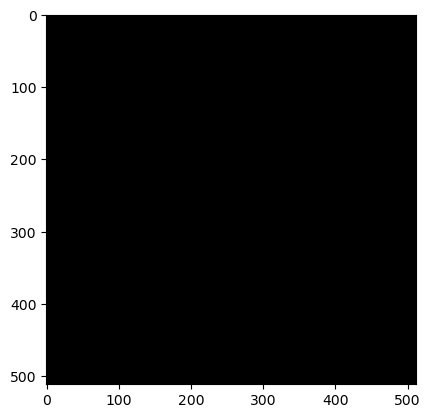

In [8]:
plt.imshow(obj_results[0].masks.data[0].permute(1,2,0).detach().cpu().numpy()*255)
plt.show()

In [9]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/(1024**2)) #MB
print(torch.cuda.memory_reserved()/(1024**2))

2928.03955078125
2958.0


In [10]:
# cd MobileSAMv2
# bash ./experiments/mobilesamv2.sh

In [11]:
args.encoder_type, encoder_path[args.encoder_type]

('tiny_vit',
 '/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/weight/mobile_sam.pt')